In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython import display

from bokeh.io import output_notebook
from bokeh.models import HoverTool
from pandas_summary import DataFrameSummary
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models.annotations import Title

from math import pi
import warnings

%matplotlib inline
output_notebook()
warnings.filterwarnings('ignore')


Loading BokehJS ...

In [2]:
def to_categorical(dataset):
    '''
    input:  original dataset
    output: convert the type of three features to categorical types and return the modified dataset
    '''
   
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')
    
    return dataset

In [3]:
def visualize_categories_L1(mean_L1):
    '''
    input:  mean_L1: dataframe containing the mean price for Level1 categories 
    output: bokeh chart visualizing the mean prices of Level1 categories
    '''
    output_file('categories_mean.html', mode="inline")

    
    mean_L1['angle'] = mean_L1['mean_price_L1']/mean_L1['mean_price_L1'].sum() * 2*pi
    mean_L1['color'] = Category20c[len(mean_L1.category_L1.unique())]
    
    TOOLTIPS = [
        ('', "@category_L1: @mean_price_L1"),
    ]
    
    p = figure(plot_height=350,tooltips=TOOLTIPS)
    p.axis.visible = False
    t = Title()
    t.text = "Mean prices for L1 Categories"
    p.title = t

    p.annular_wedge(x=0, y=1, inner_radius=0.1, outer_radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend='category_L1', source=mean_L1)



    show(p)

In [4]:
def visualize_subcategories_mean(df,category_L1):
    '''
    input:  df: dataframe containing the mean price for Level2 categories in df
            category_L1: category_L1 for which category_L2 mean prices are visualized 
    output: bokeh chart visualizing the mean prices of Level2 categories for a given category_L1
    '''
    output_file(category_L1+'_subcategories_mean.html', mode="inline")
    
    subset = df.loc[df['category_L1']==category_L1]
    subset['angle'] = subset['price']/subset['price'].sum() * 2*pi
    subset['color'] = Category20c[len(subset.category_L2.unique())]

    TOOLTIPS = [
        ("", "@category_L2: @price"),
    ]


    p = figure(plot_height=450,tooltips=TOOLTIPS)
    p.axis.visible = False
    t = Title()
    t.text = "Mean prices for L2 Categories of category "+category_L1
    p.title = t

    p.annular_wedge(x=0, y=1, inner_radius=0.2, outer_radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend='category_L2', source=subset)



    show(p)

In [5]:
# reading the dataset
train = pd.read_csv('data/train.tsv', sep='\t')

# Data Understanding

In [6]:
print("In training set, number of rows are: ", train.shape[0],"and number of columns are: ", train.shape[1])

In training set, number of rows are:  1482535 and number of columns are:  8


In [7]:
# checking a few examples of products
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
# checking nans percentage in different columns
train.isnull().mean()*100

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: float64

In [9]:
# data types of the features
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## Data Preperation: Type conversions
Three of the features represent categorical data but pandas read it either as integers or object data types. These features are:
- item_description_id
- category name
- brand_name

It is important to convert the feature data types for further data analysis

In [10]:
train = to_categorical(train)

# Data Analysis

Here, we will try to get the idea about the business. Following questions are raised after looking at the data above:
- What is the overall condition of the products?
- What is the shipment process and how it impacts the product price?
- How important is the brand name, which brands are popular and which ones are most expensive?
- What kind of products are popular and what kind of products are more expensive?
- Is there any free product?

But we will start first with analyzing the price feature. 

In [11]:
# what is the variation in prices

In [12]:
# its a continuos col
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [13]:
train.price.quantile(0.75) 

29.0

In [14]:
train.price.quantile(0.99) 

170.0

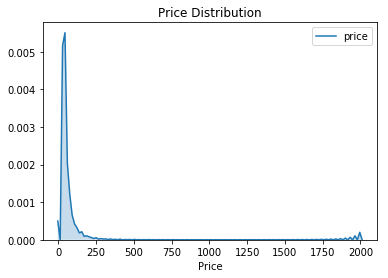

In [15]:
ax = sns.kdeplot(train.price, shade = True)
ax.set(xlabel='Price')
ax.set(title="Price Distribution")
# rightly skewed distribution not uniformly distributed

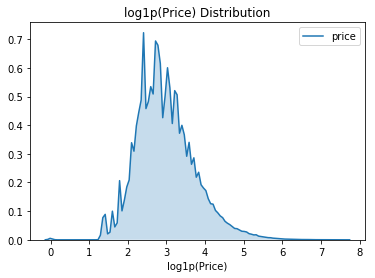

In [16]:
ax = sns.kdeplot(np.log1p(train.price), shade = True)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution")
# need a log distribution to have it uniformly distrubted, it is except right side

# Q1: What is the overall condition of the products available? 

In [17]:
item_condition_df = pd.DataFrame(train.item_condition_id.value_counts(normalize=True)*100)
item_condition_df

,item_condition_id
1,43.206332
3,29.150138
2,25.326822
4,2.155902
5,0.160806


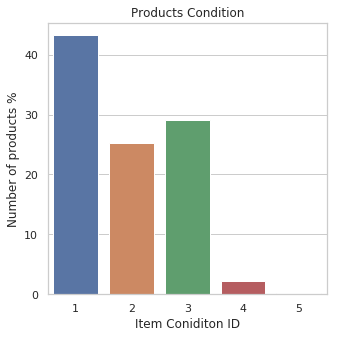

In [18]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
plt.xlabel = "Item Condition"
plt.ylabel = ""
ax = sns.barplot(x=item_condition_df.index, y=item_condition_df.item_condition_id)
ax.set(xlabel='Item Coniditon ID', ylabel='Number of products %')
ax.set(title="Products Condition")

- Check if the item_condition_id=1 represent good condition products or worse condition products
- We can check the description of the products to come up with the conclusion

In [19]:

train.item_description[train.item_condition_id==1][:10]

2     Adorable top with a hint of lace and a key hol...
3     New with tags. Leather horses. Retail for [rm]...
4             Complete with certificate of authenticity
11    (5) new vs pink body mists (2.5 oz each) Fresh...
13                                   No description yet
15    Brand new. Deluxe travel size products. Contai...
16    2 glitter eyeshadows; one in Brass and one in ...
17    Brand new in box Size: Medium Color: Coral Ret...
18    This AUTHENTIC pallete by Too Faced is brand n...
21    NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...
Name: item_description, dtype: object

In [20]:
train.item_description[train.item_condition_id==5][:10]

258     Powers on, no screen display, no external dama...
653                                    No description yet
1027                 10k gold 18" chain. Broken at clasp.
2436    For parts . Turns on and hold battery charge ....
2803    2 pounds of junk jewelry, There are some items...
3177                                   No description yet
3394                                  For parts or repair
4948         moving out so just dont wanna keep For Free！
5055                      Powers on but won't play games.
5938    Alex and ani rafaelian gold set of four bracel...
Name: item_description, dtype: object

- Words like brand new, new and shows that item_condition_id=1 represent good condition products
- Description shows that item_condition_id=5 represent worse condition products. e.g. Powers on, no screen display, Broken at clasp etc


# Q2: Who is responsible for the shipment of prodcuts and how it impacts the product price?

In [21]:
#shipping condition
shipping_df = pd.DataFrame(train.shipping.value_counts(normalize=True)*100)
shipping_df

,shipping
0,55.272557
1,44.727443


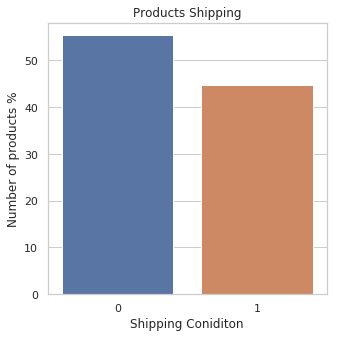

In [22]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
ax = sns.barplot(x=shipping_df.index, y=shipping_df.shipping)
ax.set(xlabel='Shipping Coniditon', ylabel='Number of products %')
ax.set(title="Products Shipping")

In [23]:
# price analysis for different shipping conditions
train.groupby('shipping').price.mean()


shipping
0    30.111778
1    22.567726
Name: price, dtype: float64

In [24]:
seller_shipping= train.loc[train.shipping==1].price
not_seller_shipping = train.loc[train.shipping==0].price

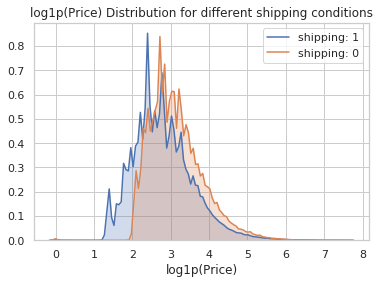

In [25]:
ax = sns.kdeplot(np.log1p(seller_shipping),label="shipping: 1",
                   shade=True, shade_lowest=False)
ax = sns.kdeplot(np.log1p(not_seller_shipping),label="shipping: 0",
                   shade=True, shade_lowest=False)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution for different shipping conditions")

# Q3: How important is the brand name, which brands are popular and which ones are most expensive?


In [26]:
train.brand_name.nunique()

4809

In [27]:
brand_names_list = list(train.brand_name.unique())
brand_names_list[:20]

[nan,
 'Razer',
 'Target',
 'Acacia Swimwear',
 'Soffe',
 'Nike',
 'Smashbox',
 "Victoria's Secret",
 'rue',
 'Scholastic',
 'UGG Australia',
 'Tarte',
 'Wet n Wild',
 'Too Faced',
 'Anthropologie',
 'Torrid',
 'Samsung',
 'FOREVER 21',
 'Air Jordan',
 'Apple']

In [28]:
branded_products = train[train.brand_name.isnull()==False]
non_branded_products = train[train.brand_name.isnull()==True]


In [29]:
branded_products.shape[0]/train.shape[0]*100

57.32431274809701

In [30]:
non_branded_products.shape[0]/train.shape[0]*100

42.675687251902986

In [31]:
branded_products.price.mean()

30.909519646338836

In [32]:
non_branded_products.price.mean()

21.13345329881362

In [33]:
#43% values contain NaNs, top most frequent brands from remaining 57% data are
train.brand_name.value_counts(normalize=True,dropna=True).nlargest(10)*100

PINK                 6.364395
Nike                 6.359100
Victoria's Secret    5.652272
LuLaRoe              3.650514
Apple                2.038235
FOREVER 21           1.786897
Nintendo             1.765835
Lululemon            1.713002
Michael Kors         1.638872
American Eagle       1.559564
Name: brand_name, dtype: float64

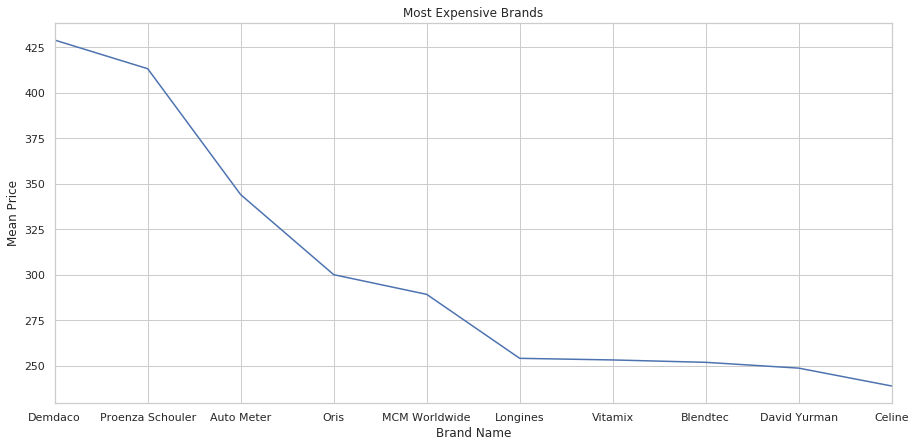

In [34]:
## most expensive brands
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['brand_name']).mean()['price'].nlargest(10).plot(ax=ax)
ax.set(xlabel='Brand Name', ylabel='Mean Price')
ax.set(title="Most Expensive Brands")

# Q4: What kind of products are popular and what kind of products are more expensive?


In [35]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [36]:
train['category_name'].value_counts(normalize=True)[:10]*100

Women/Athletic Apparel/Pants, Tights, Leggings                 4.076458
Women/Tops & Blouses/T-Shirts                                  3.141834
Beauty/Makeup/Face                                             2.325892
Beauty/Makeup/Lips                                             2.026137
Electronics/Video Games & Consoles/Games                       1.799001
Beauty/Makeup/Eyes                                             1.708093
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    1.671580
Women/Underwear/Bras                                           1.441125
Women/Tops & Blouses/Tank, Cami                                1.374061
Women/Tops & Blouses/Blouse                                    1.374061
Name: category_name, dtype: float64

In [37]:
train.groupby(train.category_name.str.count("/")).count()


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
category_name,,,,,,,,
2.0,1471819,1471819,1471819,1471819,844461,1471819,1471819,1471815
3.0,1330,1330,1330,1330,372,1330,1330,1330
4.0,3059,3059,3059,3059,2150,3059,3059,3059


In [38]:
# extract categories
train["category_L1"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+", expand=False)
train["category_L2"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+", expand=False)
train["category_L3"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)", expand=False)

## Popular Categories

In [39]:
train.category_L1.nunique()

10

In [40]:
category_L1_df = pd.DataFrame(train.category_L1.value_counts(normalize=True,dropna=False)*100)
category_L1_df


,category_L1
Women,44.814119
Beauty,14.018421
Kids,11.580772
Electronics,8.275690
Men,6.318906
Home,4.578037
Vintage & Collectibles,3.138543
Other,3.059017
Handmade,2.080356
Sports & Outdoors,1.709369


In [41]:
train.category_L1.unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', nan, 'Handmade'], dtype=object)

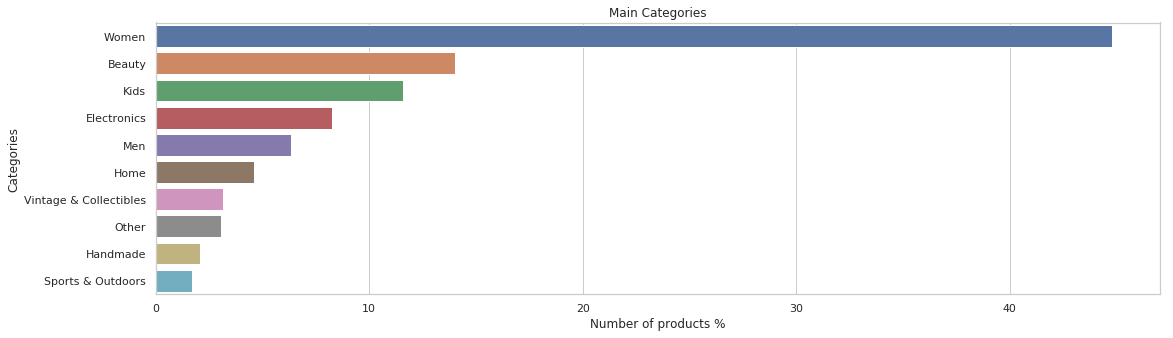

In [42]:
sns.set(style="whitegrid")
plt.subplots(figsize=(18,5))
ax = sns.barplot(y=category_L1_df.index, x=category_L1_df.category_L1)
ax.set(xlabel='Number of products %', ylabel='Categories')
ax.set(title="Main Categories")

In [43]:
train.category_L3.nunique()

870

In [44]:
train.category_L2.nunique()

113

## Popular subcategories for the most popular category "Women" 

In [45]:
category_L2_Women_df = pd.DataFrame(train[train.category_L1=="Women"].category_L2.value_counts(normalize=True,dropna=False)*100)
category_L2_Women_df

,category_L2
Athletic Apparel,18.582147
Tops & Blouses,16.099099
Shoes,11.688103
Jewelry,8.554829
Women's Handbags,6.902925
Dresses,6.887272
Women's Accessories,6.374316
Sweaters,5.164475
Underwear,5.085003
Jeans,4.867359


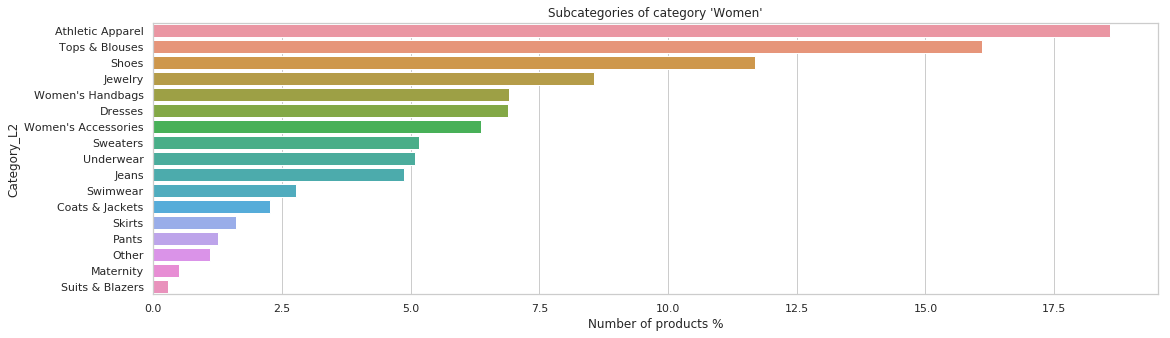

In [46]:
sns.set(style="whitegrid")
plt.subplots(figsize=(18,5))
ax = sns.barplot(y=category_L2_Women_df.index, x=category_L2_Women_df.category_L2)
ax.set(xlabel='Number of products %', ylabel='Category_L2')
ax.set(title="Subcategories of category 'Women'")

In [47]:
train.category_L3.nunique()

870

## Expensive Categories and Subcategories

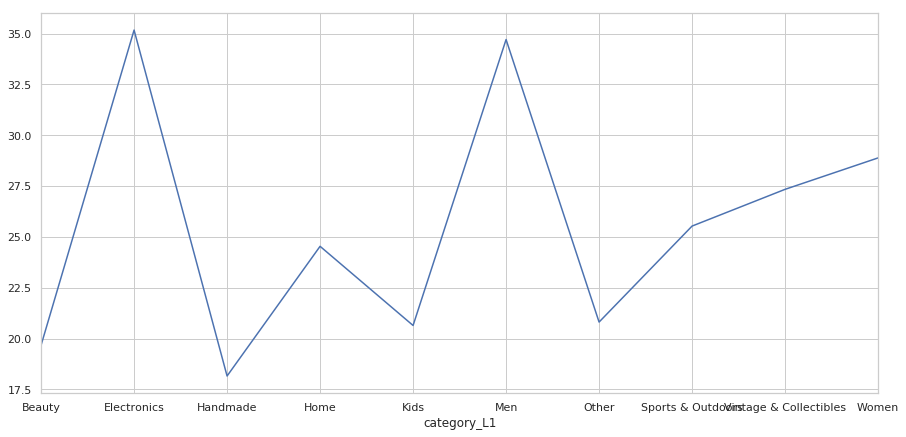

In [48]:
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['category_L1'])['price'].mean().plot(ax=ax)

In [49]:
# What kind of products are more expensive?

In [50]:
mean_L1 = pd.DataFrame(train.groupby(['category_L1']).price.mean())
mean_L1.reset_index(inplace=True)  
mean_L1=mean_L1.rename(columns = {'price':'mean_price_L1'})
mean_L1
mean_L2 = pd.DataFrame(train.groupby(['category_L1', 'category_L2']).price.mean())
mean_L2.reset_index(inplace=True)  

result = pd.merge(mean_L2, mean_L1, on='category_L1')
#result

In [51]:
visualize_categories_L1(mean_L1)

In [52]:
visualize_subcategories_mean(result,"Electronics")

# Q. Is there any free product?

In [53]:

free_products = train[train.price==0]
free_products.shape[0]

874

In [54]:
best_free_products = free_products[free_products.item_condition_id==1]
best_free_products.shape[0]

303

In [55]:
best_free_products_shipping = best_free_products[best_free_products.shipping==1]
best_free_products_shipping.shape[0]

125

In [56]:
best_free_products_shipping[best_free_products_shipping.brand_name=='Nike']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_L1,category_L2,category_L3
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N...",Women,Athletic Apparel,"Pants, Tights, Leggings"
28091,28091,Jordan Cris Shoes Size 2,1,Kids/Boys 0-24 Mos/Shoes,Nike,0.0,1,Bought from another seller and too small,Kids,Boys 0-24 Mos,Shoes
1172410,1172410,BRAND NEW - Men's Nike Tank,1,Men/Athletic Apparel/Shirts & Tops,Nike,0.0,1,Tags still attached- Men's Red Nike cut off ta...,Men,Athletic Apparel,Shirts & Tops
